# Inpainting with the deep decoder

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
#%matplotlib notebook

import os

import warnings
warnings.filterwarnings('ignore')

from include import *
from PIL import Image
import PIL

import numpy as np
import torch
import torch.optim
from torch.autograd import Variable

GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    print("num GPUs",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor

num GPUs 1


## Helpers: Show image

In [2]:
def myimgshow(img):
    img = img.transpose(1, 2, 0)
    if (len(img.shape) == 3):
      plt.imshow(np.clip(np.squeeze(img),0,1))
    else: #plot grayscale
      plt.imshow(np.clip(img,0,1))
    plt.grid(False)
    plt.axis('off');
    plt.colorbar()
    
def axisimgshow(plt,img):
    img = img.transpose(1, 2, 0)
    if (len(img.shape) == 3):
      plt.imshow(np.clip(np.squeeze(img),0,1))
    else: #plot grayscale
      plt.imshow(np.clip(img,0,1))

## Load image

In [3]:
path = './test_data/'
img_name = "poster"

img_path = path + img_name + ".png"
img_pil = Image.open(img_path)
img_np = pil_to_np(img_pil)
img_clean_var = np_to_var(img_np).type(dtype)

output_depth = img_np.shape[0]
img_mask_pil = Image.open('./test_data/mask.png')
mask_np = pil_to_np(img_mask_pil)
mask_np = np.array([mask_np[0,:,:] / np.max(mask_np) ] * output_depth)
mask_var = np_to_var(mask_np).type(dtype)

## Generate inpainted image

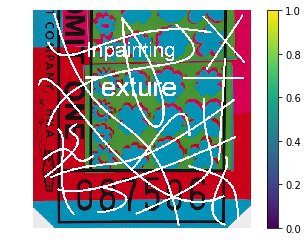

In [4]:
repo_path = '.'
dir_name = 'test_data'
img_name = "poster.png"

img_path = os.path.join(repo_path, dir_name, img_name)
img_pil = Image.open(img_path)
img_np = pil_to_np(img_pil)
img_clean_var = np_to_var(img_np).type(dtype)

output_depth = img_np.shape[0]
img_mask_path = img_path = os.path.join(repo_path, dir_name, "mask.png")

img_mask_pil = Image.open(img_mask_path)
mask_np = pil_to_np(img_mask_pil)
mask_np = np.array([mask_np[0,:,:] / np.max(mask_np) ] *output_depth)
mask_var = np_to_var(mask_np).type(dtype)

img_noisy_var = img_clean_var * mask_var
img_noisy_np = var_to_np(img_noisy_var)
myimgshow(img_noisy_np)

## Load Masked / Painted Image

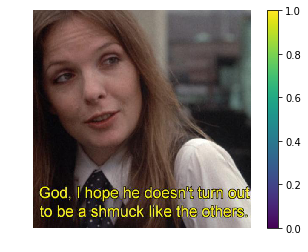

In [5]:
dir_name = 'test_data'
img_name = "subtitle_easy.jpg"
fullfilename = os.path.join(repo_path, dir_name, img_name)

img_pil = Image.open(fullfilename)
img_np = pil_to_np(img_pil)
img_np = np.concatenate((img_np,np.ones((1,512,512))), axis=0)

img_clean_var = np_to_var(img_np).type(dtype)
img_noisy_var = img_clean_var
img_noisy_np = var_to_np(img_noisy_var)
myimgshow(img_noisy_np)

## Recover image

In [6]:
%%time
k = 256 #256
numit = 40000

rnd = 500
rn = 0.005

num_channels = [k]*5
net = decodernw(output_depth,num_channels_up=num_channels,upsample_first = True).type(dtype)

print("number of parameters: ", num_param(net))

mse_n, mse_t, ni, net = fit( num_channels=num_channels,
                        reg_noise_std=rn,
                        reg_noise_decayevery = rnd,
                        num_iter=numit,
                        LR=0.0025,
                        img_noisy_var=img_noisy_var,
                        net=net,
                        img_clean_var=img_clean_var,
                        mask_var = mask_var,
                        find_best=True,
                        )

number of parameters:  397312
network input shape:  [1, 256, 16, 16]
optimize with adam 0.0025
Wall time: 2h 51s Train loss 0.000022  Actual loss 0.000367 Actual loss orig 0.000367 MSE Loss 0.000367 Noise Energy 0.000000                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

### Show Result

Wall time: 378 ms


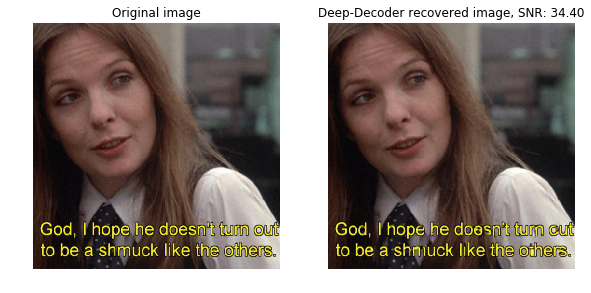

In [8]:
%%time
show_graph(mse_n, mse_t)
fig = plt.figure(figsize = (15,15)) 
    
ax1 = fig.add_subplot(131)
axisimgshow(ax1,img_np) 
ax1.set_title('Original image')
ax1.axis('off')

if (psnr(img_np,img_noisy_np) != float("inf")):
  ax2 = fig.add_subplot(132)
  axisimgshow(ax2,img_noisy_np)
  ax2.set_title( "Noisy observation, PSNR: %.2f" % psnr(img_np,img_noisy_np) )
  ax2.axis('off')

  ax3 = fig.add_subplot(133)
else:
  ax3 = fig.add_subplot(132)

out_img_np = net( ni.type(dtype) ).data.cpu().numpy()[0]
axisimgshow(ax3,out_img_np)
ax3.set_title( "Deep-Decoder recovered image, PSNR: %.2f" % psnr(img_np,out_img_np) ) 
ax3.axis('off')  